# Checking the IAMIP2 output of ACCESS-OM2 for data publication
- Author: Hakase Hayashida
- Created: 2022-06-28
- This notebook reads the IAMIP2 output of ACCESS-OM2 produced by shell script and conducts basic analysis for checking to ensure it is ready for data publication

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from cosima_cookbook import explore
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import os.path
import glob
from tqdm.notebook import tqdm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cft 
import cftime
import dask

In [4]:
import climtas.nci
climtas.nci.Client(malloc_trim_threshold='64kib')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/ood-vn43/44490/proxy/8787/status,
Dashboard: /node/ood-vn43/44490/proxy/8787/status,Workers: 1
Total threads: 1,Total memory: 2.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37479,Workers: 1
Dashboard: /node/ood-vn43/44490/proxy/8787/status,Total threads: 1
Started: Just now,Total memory: 2.81 GiB
Comm: tcp://127.0.0.1:36235,Total threads: 1
Dashboard: /node/ood-vn43/44490/proxy/42751/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:33033,


In [2]:
exp_i = ['his','exc','con','CMCC-ESM2ssp126','CMCC-ESM2ssp585','EC-Earth3ssp126','EC-Earth3ssp585']
exp_o = ['historical','exclusion','control','ssp126-CMCC-ESM2','ssp585-CMCC-ESM2','ssp126-EC-Earth3','ssp585-EC-Earth3']

In [3]:
dir_o = '/g/data/v45/hh0162/projects/IAMIP2/ACCESS-OM2/'

In [4]:
dsg = xr.open_mfdataset(dir_o+'ACCESS-OM2_grid.nc')
dsg

<xarray.Dataset>
Dimensions:    (y: 300, x: 360)
Dimensions without coordinates: y, x
Data variables:
    area       (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    latitude   (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    mask       (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    title:             sea ice model output for CICE
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    comment:           This year has 365 days
    comment2:          File written on model date 19580102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    io_flavor:         io_pio
    NCO:               netCDF Operators version 5.0.5 (Homepage = http://nco....
    history:           Fri Jul  1 10:50:44 2022: ncks -O -4 -L 9 /g/data/v45/...

In [5]:
ds = xr.open_mfdataset(dir_o+exp_o[0]+'/intppbi/*_2018.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 365, y: 300, x: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
Dimensions without coordinates: y, x, bnds
Data variables:
    intppbi    (time, y, x) float64 dask.array<chunksize=(365, 300, 360), meta=np.ndarray>
    latitude   (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes: (12/14)
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jul  6 18:21:09 2022: ncks -O -4 -L 9 /g/data/v45/...
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    title:             sea ice model output for CICE
    contents:          Diagnostic and Prognostic Variables
    ...                ...
    comment2:          File written on model date 20180102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    io_flavor:         io_pio
    NCO:               netCDF Operators version 5.0.6 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

In [6]:
ds.intppbi

<xarray.DataArray 'intppbi' (time: 365, y: 300, x: 360)>
dask.array<open_dataset-e51c94c8aee4e33bdac884ba3e065ec5intppbi, shape=(365, 300, 360), dtype=float64, chunksize=(365, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
Dimensions without coordinates: y, x
Attributes:
    long_name:     Vertically integrated primary organic carbon production by...
    units:         mol m-2 s-1
    cell_methods:  time: mean
    time_rep:      averaged

### ppia: ice algal NPP in [Tg year-1]

In [7]:
ppia = 1e-12*12.011*86400*(ds.intppbi*dsg.area).sum(dim='time')
ppia

<xarray.DataArray (y: 300, x: 360)>
dask.array<mul, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [13]:
ppiaNH = np.array(ppia.where(dsg.latitude>0,other=0).sum())

In [14]:
ppiaNH

array(12.40789891)

In [16]:
ppiaSH = np.array(ppia.where(dsg.latitude<0,other=0).sum())

In [17]:
ppiaSH

array(27.65233544)

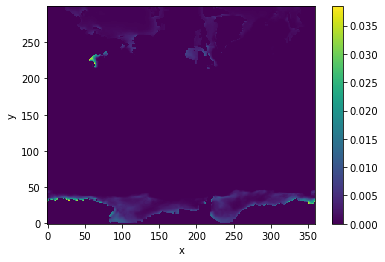

In [10]:
ppia.plot()

In [6]:
#threshold ice concentration for quantities over the sea-ice area
aiceth = 0.01
#0=cice output, 1=mom output
var_t = [0,0,0,0,0,0,0,1,1,1,
         1,1,1,1,1,1,
         1,1,1,1,1,1,1
        ]
var_i = ['algal_N','PP_net','aice','hi','hs','skl_Nit','fswthru_ai','surface_temp','surface_salt','mld',
         'npp1','npp2d','pprod_gross_2d','wdet100','radbio1','stf09',
         'surface_no3','surface_fe','surface_phy','surface_zoo','surface_det','surface_alk','surface_adic'
        ]
uni_i = ['mmol N m-2','mg C m-2 d-1','1','m','m','mmol m-2','W m-2','K','PSU','m',
         'mmol N m-2 s-1','mmol N m-2 s-1','mmol N m-2 s-1','mmol N m-2 s-1','W m-2','mmol C m-2 s-1',
         'mmol N m-3','umol Fe m-3','mmol N m-3','mmol N m-3','mmol N m-3','mmol m-3','mmol m-3'
        ]
var_o = ['phycbi','intppbi','siconc','sithick','sisnthick','no3bi','parbi','sst','sss','mldts2t',
         'intppos','intpp','intgp','epc100','paros','fgco2',
         'no3os','dfeos','phycos','zoocos','detcos','talkos','dissicos'
        ]
uni_o = ['mol m-3','mol m-2 s-1','%','m','m','mol m-3','W m-2','C','PSU','m',
         'mol C m-2 s-1','mol C m-2 s-1','mol C m-2 s-1','mol C m-2 s-1','W m-2','kg C m-2 s-1',
         'mol N m-3','mol Fe m-3','mol C m-3','mol C m-3','mol C m-3','mol m-3','mol m-3'
        ]
confa = [1e-3/0.03*106/16,1e-3,1e-3/12.011/86400,100,1,1,1e-3/0.03,1,'273.15',1,1,
         1e-3*106/16,1e-3*106/16,1e-3*106/16,1e-3*106/16,1,1e-6*12.011,
         1e-3,1e-6,1e-3*106/16,1e-3*106/16,1e-3*106/16,1e-3,1e-3
        ]
#0=grid cell average, 1=sea-ice-covered area
conia = [1,1,0,1,1,1,0,0,0,0,
         0,0,0,0,0,0,
         0,0,0,0,0,0,0
        ]
long_o = ['Bottom-ice algae carbon concentration over sea-ice-covered area',
          'Vertically integrated primary organic carbon production by bottom-ice algae over sea-ice-covered area',
          'Percentage of grid cell covered by sea ice',
          'Actual sea ice thickness (sea-ice volume divided by sea-ice-covered area)',
          'Actual snow thickness (snow volume divided by snow-covered area)',
          'Bottom-ice dissolved nitrate concentration over sea-ice-covered area',
          'Downwelling photosynthetic radiance flux at bottom ice over sea-ice-covered area',
          'Sea surface temperature',
          'Sea surface salinity',
          'Ocean mixed layer thickness defined by sigma-t',
          'Vertically integrated primary organic carbon production by phytoplankton over sea surface layer',
          'Vertically integrated primary organic carbon production by phytoplankton',
          'Vertically integrated gross primary organic carbon production by phytoplankton',
          'Downward flux of particulate organic carbon at 100m',
          'Downwelling photosynthetic radiance flux at sea surface',
          'Sea surface downward flux of carbon dioxide',
          'Sea surface dissolved nitrate concentration',
          'Sea surface dissolved iron concentration',
          'Sea surface phytoplankton carbon concentration',
          'Sea surface zooplankton carbon concentration',
          'Sea surface detritus carbon concentration',
          'Sea surface total alkalinity',
          'Sea surface dissolved inorganic carbon concentration'
         ]
          
          
          

In [ ]:
for j in range(1):#np.size(exp_i)):
    for i in range(1):#np.size(var_i)):
        os.makedirs(dir_o+exp_o[j]+'/'+var_o[i],exist_ok=True)
        data = cc.querying.getvar('1deg_iamip2_'+exp_i[j], var_i[i], session, frequency='1 daily')
        if var_i[i] == 'surface_temp':
            datanew = data - 273.15
        else:
            datanew = data * confa[i]
        datanew = datanew.to_dataset(name=var_o[i])
        
        #20220608: update that we no longer provide output divided by sea ice area. all are grid cell averages instead.
        #division by sea-ice-covered area
        #following the CMORisation of CMIP6, do the division when sea-ice-cover is more than 0.001. otherwise, set the value to zero,
        #assuming no sea ice, to prevent division by small numbers.
        #this is the same as done for ACCESS submission to CMIP6, by Chloe Mackallah.
        #see https://git.nci.org.au/cm2704/APP4/-/blob/master/subroutines/app_functions.py#L1290
#        if conia[i] == 1:
#            aice = cc.querying.getvar('1deg_iamip2_'+exp_i[j], 'aice', session, frequency='1 daily')
#            datanew = (datanew/aice).where((aice>aiceth)|aice.isnull(),other=0)
        datanew.attrs.update(data.attrs)
        #treatment for cice output
        if var_t[i] == 0:
            datanew['time'] = datanew.time - np.timedelta64(12, 'h')
#            del datanew.attrs['time_bounds']
#            datanew.attrs['time_bounds'][:,0] = (datanew.time - np.timedelta64(12, 'h')).values
#            datanew.attrs['time_bounds'][:,1] = (datanew.time + np.timedelta64(12, 'h')).values
            datanew = datanew.drop_vars({'ULON','ULAT'})
            datanew = datanew.rename({'TLON': 'longitude','TLAT': 'latitude','nj':'y','ni':'x'})        
        datanew.attrs.update({'units': uni_o[i]})
        datanew.attrs.update({'long_name': long_o[i]})
#        datanew = datanew.rename(var_o[i])
        datanew.load().to_netcdf(
            dir_o+exp_o[j]+'/'+var_o[i]+'/'+var_o[i]+'_day_IAMIP2_ACCESS-OM2_'+exp_o[j]+'_'+str(int(datanew['time.year'][0]))+'-'+str(int(datanew['time.year'][1]+1))+'.nc',
            unlimited_dims='time',
            encoding={var_o[i]:{'zlib': True,'complevel': 1},'time':{'dtype':'i4'}})
        #The encoding for time was needed to be able to recognise the time dimension in ncview. The solution was found below:
        # https://stackoverflow.com/questions/48895227/output-int32-time-dimension-in-netcdf-using-xarray
        

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [47]:
datanew.attrs['time_bounds'][:,0].values()

TypeError: 'numpy.ndarray' object is not callable

### 20220607 tested to see if 

In [13]:
data = cc.querying.getvar('1deg_iamip2_'+exp_i[j], var_i[i], session, frequency='1 daily')


NameError: name 'j' is not defined

In [7]:
ds = xr.open_dataset(dir_o+exp_o[j]+'/'+var_o[i]+'/'+var_o[i]+'_day_IAMIP2_ACCESS-OM2_'+exp_o[j]+'_'+str(int(datanew['time.year'][0]))+'-'+str(int(datanew['time.year'][1]+1))+'.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 22645, y: 300, x: 360)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01T12:00:00 ... 2019-12-31T12:00:00
    longitude  (y, x) float32 ...
    latitude   (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    phycbi     (time, y, x) float32 ...

### although 0.001 threshold is the one used for CMIP6, it yields huge concentrationf or ice algal biomass

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


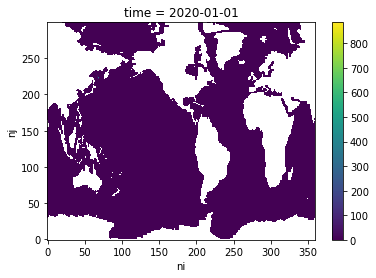

In [11]:
data2 = (datanew/aice).where((aice>0.001)|aice.isnull(),other=0)
data2[-1,:,:].plot()

### changing the threshold to 0.01 reduces the biomass by an order of magnitude, which seems reasonable.
- for ACCESS-OM2, 0.01 of ice concentration means less than 1 km2 of sea ice area (much smaller than this in reality as the grid cell is much smaller at poles). i think setting this threshold is fine/better than going finer, as sea ice will be not accessible for obs?

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


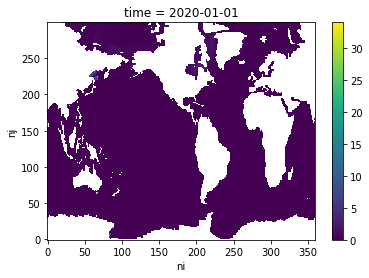

In [12]:
data2 = (datanew/aice).where((aice>0.01)|aice.isnull(),other=0)
data2[-1,:,:].plot()

In [17]:
datanew.attrs.update(data.attrs)
datanew

<xarray.DataArray 'algal_N' (time: 22645, nj: 300, ni: 360)>
dask.array<mul, shape=(22645, 300, 360), dtype=float32, chunksize=(1, 150, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-02 1958-01-03 ... 2020-01-01
    TLON     (nj, ni) float32 dask.array<chunksize=(150, 180), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(150, 180), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(150, 180), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(150, 180), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          mmol/m^2
    long_name:      ice bottom algae (nitrogen)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 22645, d2: 2)>\nda...
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_iamip2_his/output0...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-11-10
    description:    1 degree ACCESS-OM2 global model configuration under inte...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...

In [20]:
datanew.cf

AttributeError: 'DataArray' object has no attribute 'cf'

### an attempt to display in mg/m3 chlorophyll

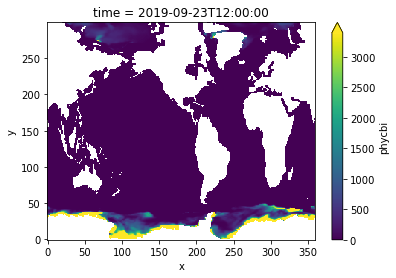

In [47]:
(1e3*12/28*datanew[-100,:,:]).plot(robust=True)

In [52]:
data.time

<xarray.DataArray 'time' (time: 22645)>
array(['1958-01-02T00:00:00.000000000', '1958-01-03T00:00:00.000000000',
       '1958-01-04T00:00:00.000000000', ..., '2019-12-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1958-01-02 1958-01-03 ... 2020-01-01
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [51]:
datanew.time

<xarray.DataArray 'time' (time: 22645)>
array(['1958-01-01T12:00:00.000000000', '1958-01-02T12:00:00.000000000',
       '1958-01-03T12:00:00.000000000', ..., '2019-12-29T12:00:00.000000000',
       '2019-12-30T12:00:00.000000000', '2019-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T12:00:00 ... 2019-12-31T12:00:00